In [1]:
import pysam
import numpy as np
import cPickle as pickle

In [2]:
from collections import Counter
from math import log

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

-----------------

### Mapping statistics

In [ ]:
#AAAGTT  ATATAG  ATCAAA  CCCTGG  CCGGAC  GACCGC  GGCGTC  GTTCGA  TAAAGT  TCTGCA  TTAATC

In [38]:
sample = 'CCGGAC'
in_file = '/data/UMI/data/MUS/sample_' + sample + '.bam'
out_file = 'multi_' + sample + '.pkl'

In [39]:
st = pysam.AlignmentFile(in_file, "rb")

In [180]:
st.reset()
reads = st.fetch(until_eof=True)

multi = {}
for r in reads: #st.head(1000):
    if not r.is_unmapped and r.get_tag('NH') > 1:
for r in reads: #st.head(1000):
    if not r.is_unmapped and r.get_tag('NH') > 1:
        
        qname = r.query_name
        nm = r.get_tag('NM')
        
        if qname in multi:
            multi[qname].append(nm)
        else:
            multi.update({qname:[nm]})

pickle.dump(multi, open(out_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
#multi = pickle.load(open(out_file, 'r'))

In [186]:
no_stats = []
for q in multi:
    no_stats.append(len(multi[q]))
    
mapping_stats = Counter(no_stats)

In [14]:
from pyUMI.umiViews import tag_based_generator
st.reset()
g = tag_based_generator(st, tag='NH', values=[2])
l = [i.reference_name for i in g]

In [21]:
def scoring_hash_table(pysam_iter):

    pysam_iter.reset()
    g = tag_based_generator(pysam_iter, tag='NH', values=[2])

    htab = {}
    for r in g:
        qn = r.query_name
        score = r.get_tag('AS')
        nm = r.get_tag('NM')
        prop = (score, nm)
        if qn in htab:
            htab[qn].append(prop)
        else:
            htab.update({qn: [prop]})

    return htab

In [40]:
g = tag_based_generator(st, tag='NH', values=[2])

hst = scoring_hash_table(st)

In [46]:
odds = []
for k in hst.keys():
    if len(hst[k]) == 1:
        odds.append(k)
odds

['HISEQ:280:C9J9KANXX:2:1309:16471:79479',
 'HISEQ:280:C9J9KANXX:2:1201:6117:84499',
 'HISEQ:280:C9J9KANXX:2:2113:11579:43466',
 'HISEQ:280:C9J9KANXX:1:2103:8419:8219']

In [47]:
st.reset()
reads = st.fetch(until_eof=True)
for r in reads:
    if r.query_name in odds:
        print r

HISEQ:280:C9J9KANXX:1:2103:8419:8219	0	7	89091964	3	9S26M1I14M	-1	-1	41	GGACGGGAGCCGTCCGTCCGTCCCTGCTGGTCTCTTGTCTAGAGAGTGCT	array('B', [32, 29, 27, 31, 30, 29, 35, 29, 28, 36, 38, 38, 33, 38, 35, 36, 38, 37, 38, 38, 38, 38, 38, 38, 38, 34, 33, 16, 37, 38, 38, 34, 37, 38, 16, 16, 16, 27, 28, 16, 27, 16, 28, 29, 27, 34, 37, 35, 34, 37])	[('XC', 'CCGGAC'), ('XF', 'INTRONIC'), ('PG', 'STAR'), ('RG', 'A'), ('NH', 2), ('NM', 1), ('XM', 'CGAGTCGCGG'), ('UQ', 0), ('AS', 35)]
HISEQ:280:C9J9KANXX:2:1201:6117:84499	0	7	89091964	3	9S26M1I14M	-1	-1	41	GGACGGGAGCCGTCCGTCCGTCCCTGCTGGTCTCTTGTCTAGAGAGTGCT	array('B', [27, 31, 27, 29, 15, 14, 36, 14, 34, 38, 38, 38, 27, 38, 38, 38, 33, 38, 38, 27, 35, 38, 32, 38, 38, 36, 35, 16, 16, 36, 25, 34, 31, 37, 31, 34, 16, 16, 16, 37, 29, 31, 16, 28, 30, 2, 2, 2, 2, 2])	[('XC', 'CCGGAC'), ('XF', 'INTRONIC'), ('PG', 'STAR'), ('RG', 'A'), ('NH', 2), ('NM', 1), ('XM', 'CGAGTCGCGG'), ('UQ', 0), ('AS', 35)]
HISEQ:280:C9J9KANXX:2:1309:16471:79479	0	7	89091964	3	9S26M1I1

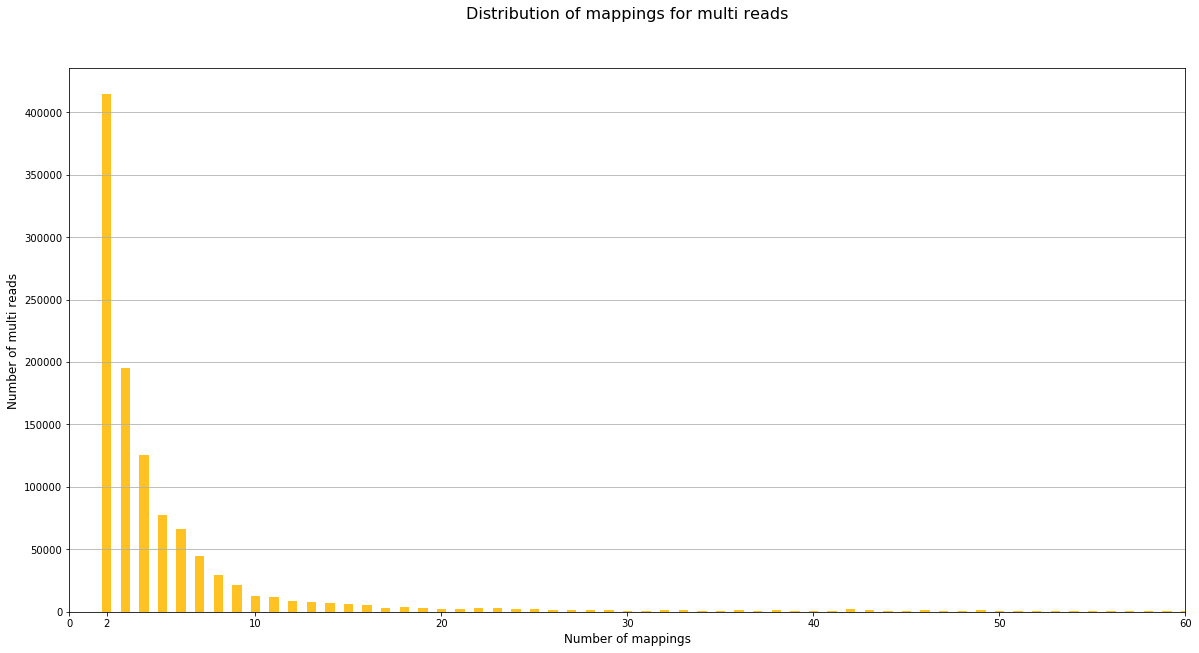

In [187]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.grid()
ax = plt.subplot(111)
plt.title('Distribution of mappings for multi reads', y=1.08, fontsize=16)
plt.xlabel('Number of mappings', fontsize=12)
plt.ylabel('Number of multi reads', fontsize=12)

x_ticks = range(0, max(mapping_stats.keys()), 10)
x_ticks.append(min(mapping_stats.keys()))
plt.xticks(x_ticks)
ax.xaxis.grid()
plt.xlim(0, 60)
ax.bar(mapping_stats.keys(), mapping_stats.values(), width=0.5, color='#FFC222')
#plt.savefig('mapping_dist')

### Heatmap plot of mismatch types for multimap = 2

In [188]:
twos = []
for q in multi:
    if len(multi[q]) == 2:
        twos.append(tuple(multi[q]))
        
c = Counter(map(frozenset, twos))
heats = {tuple(s): count for s, count in c.most_common()}

In [190]:
for h in heats:
    if len(h) == 1:
        val = heats[h]
        heats.pop(h)
        h = (h[0], h[0])
        heats.update({h:val})

In [198]:
d = max(heats)[0] + 1

In [205]:
a = np.zeros((d, d))
a_scaled = np.zeros((d, d))

In [206]:
for h in heats:
    i, j = h
    a[i][j] = heats[h]

In [207]:
for h in heats:
    i, j = h
    a_scaled[i][j] = log(heats[h])

-----------------------------------------

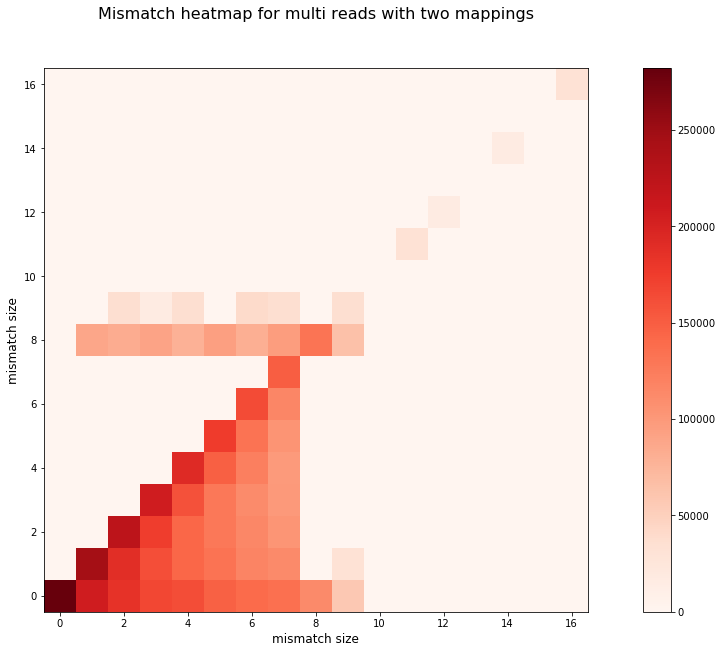

In [209]:
fig = plt.figure(figsize=(20, 10))
heatmap = plt.imshow(a, cmap=plt.cm.Reds)
heatmap.remove()
plt.title('Mismatch heatmap for multi reads with two mappings', y=1.08, fontsize=16)
plt.xlabel('mismatch size', fontsize=12)
plt.ylabel('mismatch size', fontsize=12)
plt.imshow(a_scaled, cmap=plt.cm.Reds, origin='lower')
plt.colorbar(heatmap)
#plt.savefig('mismatch_hmap_2')

### Group distribution of mismatch variants for multmaps

In [210]:
def diffs(l):
    return len(np.unique(l))

In [211]:
for i in range(2, 102, 1):
    locals()['mapping_%d' %i] = []

In [212]:
for i in range(2, 102, 1):
    for q in multi:
        if len(multi[q]) == i:
            locals()['mapping_%d' %i].append(multi[q])

In [213]:
for i in range(2, 102, 1):
    df = [diffs(l) for l in locals()['mapping_%d' %i]]
    locals()['diffs_%d' %i] = Counter(df)

In [214]:
def round_more(dict):
    new_dict = {}
    new_key = 'More'
    new_val = 0
    
    for k in dict:
        if k > 2:
            new_val += dict[k]
        else:
            new_dict.update({k:dict[k]})
            
    if new_val:
        new_dict.update({new_key:new_val})
        
    return new_dict

In [215]:
for i in range(2, 102, 1):
    locals()['df_%d' %i] = round_more(locals()['diffs_%d' %i])

In [216]:
for i in range(2, 102, 1):
    locals()['labels_%d' %i] = locals()['df_%d' %i].keys()
    locals()['sizes_%d' %i] = locals()['df_%d' %i].values()

In [217]:
cs = ['#FFC222','#F78F1E', '#EE3224']

In [218]:
rows = 2
cols = 4
plots = 100

In [219]:
def new_pos(i, j, rows = rows, cols = cols):
    
    if j == cols -1:
        i += 1
        j = 0
    else:
        j += 1
    
    return i, j

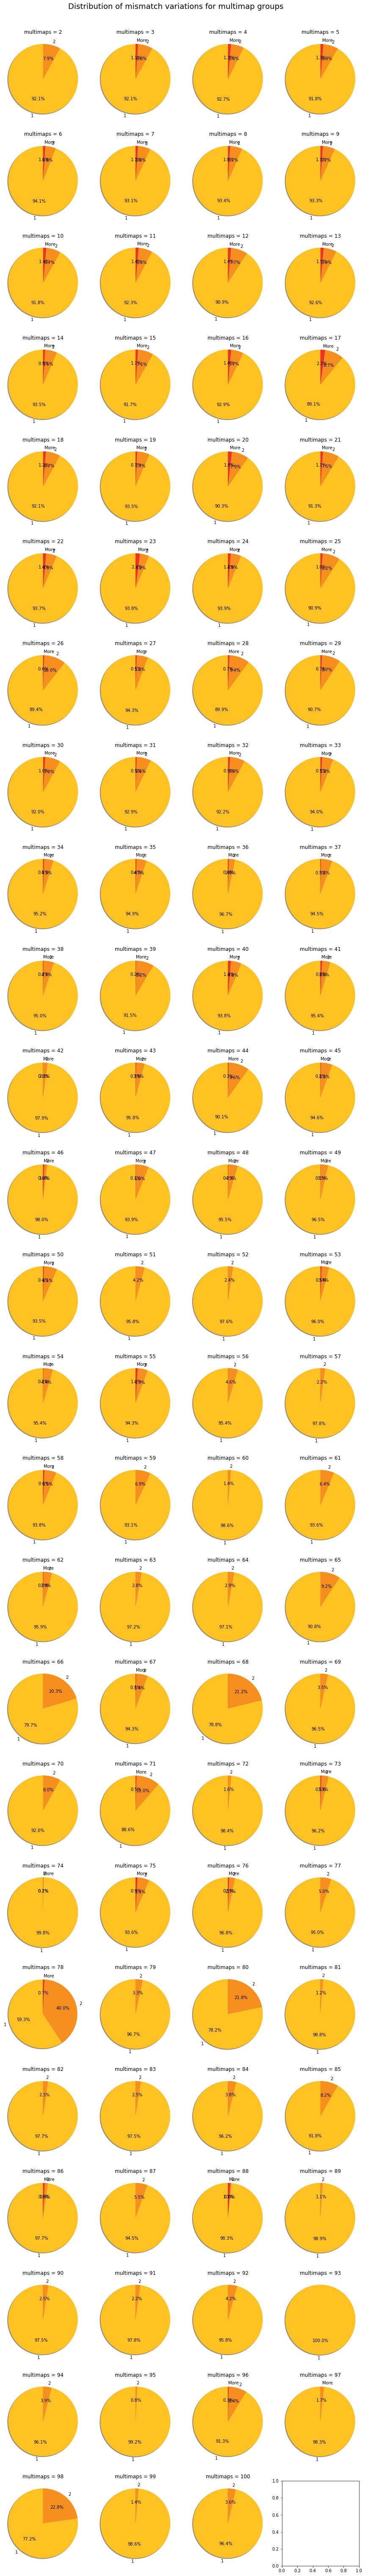

In [220]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

total_rows = plots / cols 
# Four polar axes
f, axarr = plt.subplots(total_rows, cols, figsize=(15,110))


i = j = 0

for item in range(2, 101, 1):
    
    l = locals()['labels_%d' %item]
    s = locals()['sizes_%d' %item]
    
    axarr[i, j].pie(s, labels = l, autopct='%1.1f%%', shadow=True, startangle=90, colors=cs)
    axarr[i, j].axis('equal')
    axarr[i, j].set_title('multimaps = %d' %item)
    
    i, j = new_pos(i, j)

# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.2, wspace= None)
plt.suptitle('Distribution of mismatch variations for multimap groups', fontsize= 18, y= .89)

#plt.show()
#plt.savefig('mm_dist')